<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

# BM42: The Next Clue in Hybrid Search

***Reference:*** [https://qdrant.tech/articles/bm42/](https://qdrant.tech/articles/bm42/)

***Github:***: [https://github.com/qdrant/bm42_eval](https://github.com/qdrant/bm42_eval)

## Relevance of BM 25

BM 25 has been the core of many search engines like Google, since a very long time. It has performed exceptionally well though semantic search outperforms it in most scenarios and is therefore considered the gold-standard.
Regardless, BM 25 had a few powerful features because of which it continues to be used:
- Focus on the most important words.
- Handle long vs. short documents well.
- Do a better job with unusual or rare queries (something dense embeddings struggle with)


## BM25: Fading Relevance in the Age of RAGs

But in **RAG (Retrieval-Augmented Generation)**:

- We split documents into small chunks (like 100–300 words)

- Each chunk is short and similar in length

What happens because of that?
- A word usually appears only once (or a few times) in a chunk → so term frequency = 1 (or quite low in any case)

- All chunks are about the same size → so document length doesn’t matter<br> <br>


**Consider the following example:**

**Query:** *"quantum teleportation"*

---

Case 1: Traditional Search (Long Documents)

Document A (1000+ words):

> "...Quantum teleportation is a technique in quantum physics...  
> Quantum teleportation allows quantum information to be transmitted...  
> The idea of quantum teleportation has gained popularity..."

Term Frequency (TF):
- "quantum" appears **5 times**
- "teleportation" appears **3 times**

Why BM25 works well here:
- High TF → boosts relevance score  
- Rare word ("teleportation") → higher IDF → **more weight**

---

Case 2: RAG (Small Chunks of ~100 words)

Chunk A:
> "Quantum teleportation is a technique in quantum physics."

Chunk B:
> "The idea of teleportation has gained popularity recently."

Characteristics:
- Each term appears only **once** → $TF = 1$
- Chunk length is consistent → **no document length advantage**

Observation:
- TF values are either **1 or 0**  
- BM25's advantage diminishes since all chunks are short and uniform in size

---

❌ That means TF and document length normalization do nothing in RAG.<br> <br>

**But what still matters?** <br>
✅ IDF still works:

“quantum” and “teleportation” are rare words across all documents → They get high IDF scores → Still help rank results well.

## Advent of BM42

The term frequency part of BM25 — term importance within a document — doesn’t work well in RAG or short chunks.
Now, Instead of using statistics (like word counts), let’s use the meaning of the document.
That’s where transformers come in — they’re great at understanding meaning.<br><br>

Now we have 2 challenges:
- How do we get word importance from a transformer?
→ Transformers don't give weights directly like BM25. So, we need a way to extract importance scores from their outputs.

- How do we avoid tokenization issues?
→ Remember, transformers split unknown words into pieces. This messes up retrieval. So we need a better way to handle or avoid bad token splits.


**What is BM42?** <br>
BM42 is a modern search scoring method that combines the best parts of BM25 and transformers.


- From BM25, it keeps the IDF (Inverse Document Frequency)
→ This gives more importance to rare query terms, just like traditional keyword search.

- From Transformers, it uses the attention scores
→ These scores help figure out which words in a document are most important to its overall meaning.<br><br>



**How BM42 gets word importance !?**<br>
When a transformer processes text, it creates something called an attention matrix (as shown in below figure) — a big table that shows how much each word “pays attention” to every other word.<br>


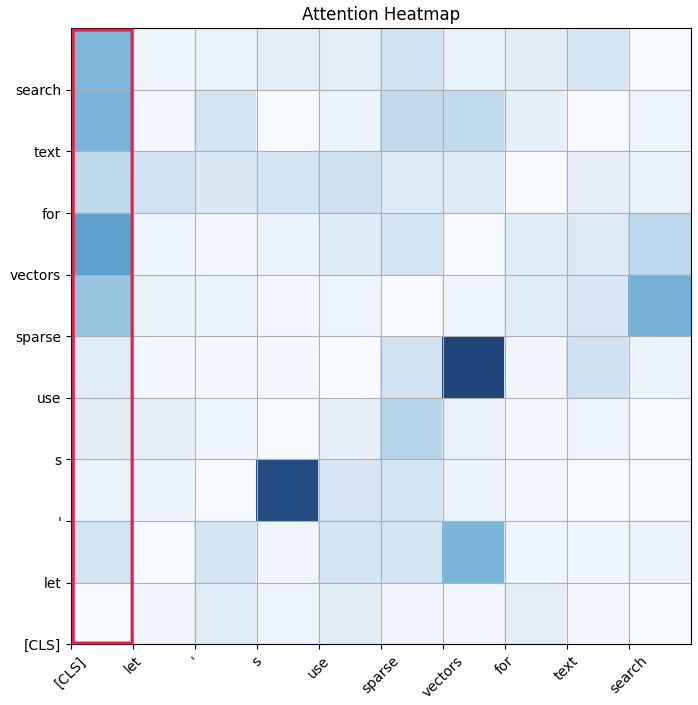

<p style="text-align:center;"><em>Source: Qdrant.tech</em></p>


In transformers, there's a special token called [CLS] that represents the entire sentence or document.
So, when [CLS] attends to other words, it’s basically asking:
>“Which words matter most to summarize this text?”



Example:
Let’s say our input is:

>"Python is a powerful language for machine learning."

The transformer will convert it into tokens like:

> <span style="color:red;">[CLS]</span>, python, is, a, powerful, language, for, machine, learning, <span style="color:red;">[SEP]</span>


Suppose the attention weights (simplified) look like this:

| **Token**   | **Attention Weight** |
|-------------|-----------------------|
| python      | 0.20 ✅               |
| is          | 0.05                  |
| a           | 0.03                  |
| powerful    | 0.15 ✅               |
| language    | 0.10                  |
| for         | 0.03                  |
| machine     | 0.20 ✅               |
| learning    | 0.22 ✅               |

What does this mean?<br>
Words like:
- "Python"

 - "Powerful"

- "Machine"

- "Learning"

...got the highest attention scores from [CLS].

These are the most important words that help summarize the meaning of the whole sentence. <br><br>




**What does BM42 do with this?** <br>
1. **Look at the attention for** <span style="color:red;">[CLS]</span>  
→ This shows how much <span style="color:red;">[CLS]</span> focuses on each word in the document.

2. **Multiple heads = multiple opinions**  
→ Transformers have **multiple attention heads**. Each head might focus on different things.  
→ So, **BM42 averages all heads** to get one clear importance score per word.

3. **Fix token splits**  
→ Transformers often break words into pieces (e.g., *"unbelievable"* → *"un"*, *"##believ"*, *"##able"*)  
→ **BM42 merges them back together** and **adds up their scores** to get the full word’s importance.


<br>

**Example:**
Transformers usually have multiple attention heads (say, 6 or 12), each giving different weights.  
BM42 averages across all heads to get one final attention score per token.

So, after averaging:

| **Token**   | **Final Attention** |
|-------------|---------------------|
| python      | 0.20                |
| powerful    | 0.15                |
| machine     | 0.20                |
| learning    | 0.22                |

*(others are low and can be ignored or filtered)*

If a word like "powerful" had been split into subwords like ["power", "##ful"],
and their scores were 0.09 and 0.06, BM42 would sum them:
> powerful = 0.09 + 0.06 = 0.15

In this case, let’s assume all tokens were clean (no splitting needed).

Now BM42 forms a sparse embedding for the document using:

- >python: 0.20

- >powerful: 0.15

- >machine: 0.20

- >learning: 0.22

These values represent how important each word is to the meaning of the whole document, based on transformer attention — no word frequency or document length needed.

<br>

**Why BM42 is useful?**
- No retraining needed — works with any off-the-shelf transformer (like MiniLM)
- Interpretable — like BM25, you can understand which words influence the score
- Multilingual — works in any language, as long as you have a transformer for it
- Great for RAG — it handles short, chunked documents better than BM25